In [18]:
import importlib
import train
import models
import fhe_vec

importlib.reload(train)
importlib.reload(models)
importlib.reload(fhe_vec)

from train import *
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch
import random
from fhe_vec import FHE_VEC
from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# IRIS Dataset

In [30]:
iris_train_ds, iris_test_ds = download_IRIS()

iris_model = Linear(4, 3).to(device)
train(iris_model, iris_train_ds, epochs=1000, learning_rate=1e-2)
test(iris_model, iris_test_ds, batch_size=64)

Epoch 1/1000, Training Loss: 1.1625
Validation Loss: 0.0486, Validation Accuracy: 0.3333
Epoch 2/1000, Training Loss: 1.1533
Validation Loss: 0.0474, Validation Accuracy: 0.3333
Epoch 3/1000, Training Loss: 1.1232
Validation Loss: 0.0464, Validation Accuracy: 0.3333
Epoch 4/1000, Training Loss: 1.1323
Validation Loss: 0.0457, Validation Accuracy: 0.2917
Epoch 5/1000, Training Loss: 1.1337
Validation Loss: 0.0451, Validation Accuracy: 0.2500
Epoch 6/1000, Training Loss: 1.1177
Validation Loss: 0.0446, Validation Accuracy: 0.3750
Epoch 7/1000, Training Loss: 1.1163
Validation Loss: 0.0443, Validation Accuracy: 0.4167
Epoch 8/1000, Training Loss: 1.1172
Validation Loss: 0.0442, Validation Accuracy: 0.3750
Epoch 9/1000, Training Loss: 1.0984
Validation Loss: 0.0442, Validation Accuracy: 0.4167
Epoch 10/1000, Training Loss: 1.0978
Validation Loss: 0.0442, Validation Accuracy: 0.4167
Epoch 11/1000, Training Loss: 1.0995
Validation Loss: 0.0441, Validation Accuracy: 0.3333
Epoch 12/1000, Trai

In [31]:
fhe = FHE_VEC()
fhe_iris_model = FHELinear(iris_model, fhe)
test_fhe(fhe_iris_model, fhe, iris_test_ds, batch_size=64, scale=100)

Got Batch!
Forwarding through model!
Decrypting output!
Test Accuracy: 1.0000, 30/30


# MNIST Dataset

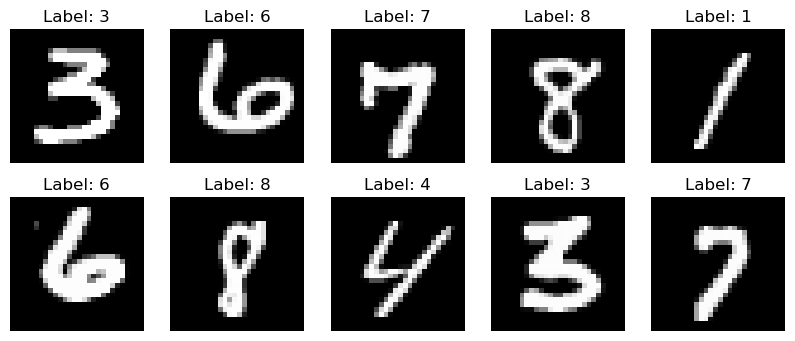

In [32]:
mnist_train_ds, mnist_test_ds = download_MNIST()
data_loader = DataLoader(mnist_test_ds, batch_size=64, shuffle=True)
images, labels = next(iter(data_loader))

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

In [35]:
mnist_model = Linear(28 * 28, 10).to(device)
train(mnist_model, mnist_train_ds, epochs=10, learning_rate=1e-2)
test(mnist_model, mnist_test_ds)

Epoch 1/10, Training Loss: 1.5875
Validation Loss: 0.0001, Validation Accuracy: 0.9171
Epoch 2/10, Training Loss: 1.5484
Validation Loss: 0.0001, Validation Accuracy: 0.9231
Epoch 3/10, Training Loss: 1.5411
Validation Loss: 0.0001, Validation Accuracy: 0.9204
Epoch 4/10, Training Loss: 1.5366
Validation Loss: 0.0001, Validation Accuracy: 0.9230
Epoch 5/10, Training Loss: 1.5338
Validation Loss: 0.0001, Validation Accuracy: 0.9239
Epoch 6/10, Training Loss: 1.5313
Validation Loss: 0.0001, Validation Accuracy: 0.9249
Epoch 7/10, Training Loss: 1.5304
Validation Loss: 0.0001, Validation Accuracy: 0.9266
Epoch 8/10, Training Loss: 1.5292
Validation Loss: 0.0001, Validation Accuracy: 0.9272
Epoch 9/10, Training Loss: 1.5275
Validation Loss: 0.0001, Validation Accuracy: 0.9257
Epoch 10/10, Training Loss: 1.5266
Validation Loss: 0.0001, Validation Accuracy: 0.9267
Test Accuracy: 0.9296, 9296/10000


In [ ]:
fhe = FHE_VEC()
fhe_mnist_model = FHELinear(mnist_model, fhe)
test_fhe(fhe_mnist_model, fhe, mnist_test_ds, batch_size=1, scale=100)

Got Batch!
Forwarding through model!


In [51]:
model = MultiLayerNet(28 * 28, 10, 200).to(device)
train(model)
test(model)

Epoch 1/5, Training Loss: 1.6299
Validation Loss: 0.0240
Epoch 2/5, Training Loss: 1.5225
Validation Loss: 0.0237
Epoch 3/5, Training Loss: 1.5071
Validation Loss: 0.0235
Epoch 4/5, Training Loss: 1.4986
Validation Loss: 0.0235
Epoch 5/5, Training Loss: 1.4924
Validation Loss: 0.0234
Test Accuracy: 0.9682, 9682/10000
